Ce notebook permet d'expliquer de A à Z comment entrainer le Mask-RCNN, et surtout comment l'adapter à la dataset que l'on souhaite, ce qui permettra de détecter tous les objets que l'on veut.
Il s'appuiera pour ce faire sur la classe SmartMov et toutes ses méthodes.
Afin d'illustrer l'ajout d'un type d'objet à détecter, nous allons utiliser des ballons. L'article original qui permet d'écrire celui-ci est le suivant :
https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46

# Importation des bibliothèques nécéssaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import PIL
import cv2
import json
import skimage.draw

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn.utils import Dataset
from SmartMov import SmartMov
from utils import sorted_nicely

# Création de la configuration

La première étape consiste à créer la classe de configuration pour notre dataset. Dans un premier temps, nous ne souhaitons détecter qu'un seul type d'objet, à savoir les ballons. Ainsi, le premier attribut à modifier sera ```NUM_CLASSES = 1+1``` puisque nous ne détectons qu'un type d'objet, auxquel s'ajoute le background.

Nous devons également fixer le batchsize dans la configuration. Le batchsize est égal au produit des attributs ```GPU_COUNT``` et ```IMAGES_PER_GPU```. Avec une carte graphique avec peu de mémoire, nous allons fixer le batchsize au plus petit possible, c'est-à-dire 1. Donc ```GPU_COUNT=1``` et ```IMAGES_PER_GPU=1```.

Ensuite, il nous faut fixer le nombre de pas d'entrainement par epochs. Notre dossier d'entrainement contient 61 images. Avec un batchsize de 1, nous allons donc fixer ce nombre de pas à 62. Ainsi ```STEPS_PER_EPOCH=62```.

Nous pouvons ensuite régler le seuil de confiance à partir duquel les objets seront détectés. Nous le fixons ici à 90%, c'est-à-dire ```DETECTION_MIN_CONFIDENCE=0.9```.

Enfin, nous devons donner un nom à cette configuration afin qu'elle soit parfaitement reconnaissable, donc ici nous fixons ```NAME='balloon'```.

Ainsi, la configuration complète est la suivante :

In [2]:
class BalloonConfig(Config):
    NAME = "balloon"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 62
    DETECTION_MIN_CONFIDENCE = 0.9

In [3]:
config = BalloonConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

En affichant la configuration complète, nous pouvons donc voir que les arguments que nous avons modifié sont présents, mais également qu'il y a beaucoup d'autres paramètres que nous ne modifierons pas, sous peine de devoir réentrainer entièrement le réseau.

Il est ensuite primordial de donner au réseau le nom de chacune des classes de la configuration. Ici nous n'avons qu'une classe, à savoir les ballons, auquel s'ajoute le background. Ainsi :

In [4]:
class_names = ['BG','balloon']

# Création du Mask-RCNN

Pour créer le Mask-RCNN, nous allons passer par les méthodes de SmartMov. Il convient donc dans un premier temps de créer une instance de SmartMov :

In [5]:
smartmov = SmartMov()

Nous pouvons donc ensuite créer le Mask-RCNN, en spécifiant que nous souhaitons charger les poids du réseau pré-entrainé sur la dataset COCO2014. Nous avons donc dans un premier temps besoin du chemin ou se situe le fichier .h5 contenant les poids du Mask-RCNN déjà entrainé. Cette variable devra être modifiée pour s'adapter à la localisation de ce fichier dans votre ordinateur.

In [6]:
MODELS_DIR = os.path.join(ROOT_DIR,"models/")
MODELS_MASKRCNN_DIR = os.path.join(MODELS_DIR,"Mask-RCNN/")
print(os.listdir(MODELS_MASKRCNN_DIR))

['logs', 'mask_rcnn_coco.h5', 'mask_rcnn_only_car.h5', 'mask_rcnn_only_person.h5', 'mask_rcnn_person_car_v2.h5']


Nous voyons donc qu'à cet emplacement se trouve bien le fichier .h5 qui nous intéresse, à savoir *mask_rcnn_coco.h5* qui contient les poids du réseau pré-entrainé. Ceci nous permettra de ne pas ré-entrainer tout le réseau mais seulement les couches nécéssaires pour s'adapter à notre dataset. Nous pouvons donc créer le Mask-RCNN de la manière suivante :

In [46]:
smartmov.create_model('rcnn',model_dir=MODELS_MASKRCNN_DIR+"logs/",config=config,reuse=True,
                      model_rcnn=MODELS_MASKRCNN_DIR+"mask_rcnn_coco.h5",class_names=class_names)

Un warning apparait parfois, il n'est pas gênant et est du à un conflit de versions de Keras.

Les paramètres de cette fonction sont nombreux mais simples :
* 'rcnn' : signifie que le modèle créé est le Mask-RCNN (SmartMov permet également de créer le U-Net qui ne nous concerne pas ici)
* 'model_dir' : correspond simplement à l'emplacement ou enregistrer les logs de l'entrainement du réseau
* 'config' : correspond à la configuration que nous avons crée plus haut
* 'reuse' : signifie que nous souhaitons ré-utiliser des anciens poids
* 'model_rcnn' : correspond à l'emplacement du fichier .h5 à charger (ici le fichier *mask_rcnn_coco.h5*)
* 'class_names' : correspond aux noms des différents objets à détecter

# Mise en place de la dataset pour l'entrainement

Pour entrainer le Mask-RCNN sur nos ballons, nous devons d'abord créer une classe *BalloonDataset* qui érite de *mrcnn.utils.Dataset*. Trois méthodes sont importantes pour entrainer ce réseau, et cette classe devra donc ressembler à cela :

In [8]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id):
        (...)
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        (...)

La méthode ```load_balloon()``` permettra de charger les images et leurs annotations, elle est appellée une fois au début du code. La méthode ```load_mask()``` permettra de retourner les masques (la vérité terrain) de l'image dont l'id aura été passé en entrée. La méthode ```image_reference()``` renvoie le chemin de l'image dont l'id est spécifié.

Nous allons commencer par créer la méthode ```load_balloon()```. Nous remarquons que cette méthode prends en paramètre trois valeurs qui sont ```dataset_dir```, ```subset``` et ```class_id```. ```dataset_dir``` sera simplement l'emplacement de la dataset dans l'ordinateur, ```subset``` sera un paramètre permettant de charger soit la dataset de train, soit celle de validation et ```class_id``` sera l'identifiant que l'on va associer à notre classe 'balloon'. La première étape est d'ajouter à notre classe tous les types d'objets pouvant être détectés. Ce types d'objets sont appellés classes (un peu confus...). Nous avons pour ce faire une méthode de la classe parent qui permet d'ajouter des classes. Il s'agit de ```add_class()```. Cette méthode prends trois paramètres en entrée :
* 'source' : chaine de caractère qui correspond à un nom arbitraire permettant de regrouper toutes les classes du même objet ensemble. Dans le cas ou nous avons plusieurs classes issues de la même dataset, il est alors facile de savoir de quelle dataset vient telle ou telle classe grâce à cet argument.
* 'class_id' : identifiant de la classe. Ne peut être 0 étant donné que celui-ci est réservé au background. Peut par contre être n'importe quel autre entier mais aucun entier ne doit manquer entre 0 et ce chiffre.
* 'class_name' : nom de la classe correspondant à cet id

Si nous utilisons cette méthode, nous avons alors :

In [34]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id=1):
        self.add_class(source="balloon", class_id=class_id, class_name="balloon")
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        (...)

Si nous avions plusieurs types d'objets à détecter, nous aurons simplement fait appel cette méthode pour chacun de ces types.

Ensuite, nous devons vérifier que le paramètre ```subset``` est bien soit 'train' soit 'val'. Ceci se fait à l'aide d'un simple *assert*. Nous créons ensuite le chemin complet de la dataset à charger, qui est simplement la concaténation de ```dataset_dir``` et ```subset```. Ainsi, le code devient :

In [35]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id=1):
        self.add_class(source="balloon", class_id=class_id, class_name="balloon")
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        (...)

Les annotations de notre dataset sont polygonales et se trouvent dans un fichier json à l'emplacement ```dataset_dir_all``` que nous venons de créer. Nous devons donc à présent lire ce fichier json pour en extraire les annotations, puis une fois ceci fait nous ne récupérons que les valeurs, nous n'avons pas besoin des clés du dictionnaire :

In [36]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id=1):
        self.add_class(source="balloon", class_id=class_id, class_name="balloon")
        assert subset in ["train", "val"]
        dataset_dir_all = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir_all, "via_region_data.json")))
        annotations = list(annotations.values())
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        (...)

Dans notre fichier d'annotations, il existe des images pour lesquels il n'y a pas d'annotations. Ces images sont tout de même dans le json et la partie qui leur correspond est "vide". Nous devons donc faire en sorte de ne pas les considérer. Nous considérons que si la 'regions' correspondant à l'image n'existe pas dans le json, nous ne prenons pas en compte cette image. Nous faisons ceci de la manière suivante :

In [37]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id=1):
        self.add_class(source="balloon", class_id=class_id, class_name="balloon")
        assert subset in ["train", "val"]
        dataset_dir_all = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir_all, "via_region_data.json")))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        (...)

A ce stade, nous avons donc ajouté toutes les classes qui nous intéressent et nous avons lu les bonnes annotations. Nous pouvons donc commencer à ajouter les images à notre dataset. Pour ce faire, nous allons utiliser la méthode ```add_image()``` de la classe parent. Cette méthode prends plusieurs paramètres en entrée :
* 'source' : même chose que pour la méthode ```add_class()```
* 'image_id' : identifiant de l'image dans la dataset (arbitraire)
* 'path' : chemin de l'image dans l'ordinateur
* '\*\*kwargs' : un dictionnaire d'informations qui seront ensuite utiles pour la lecture du masque

Nous allons donc dans un premier temps parcourir toutes les annotations que nous avons lues plus haut, puis nous allons lire les polygones correspondants. Ces polygones sont dans la partie 'regions' du json et correspondent à la clé 'shape_attribute'. Selon la version de l'outil utilisé lors de l'annotation, 'regions' peut être soit un dictionnaire, soit une liste, nous devons donc prendre en compte ces deux cas :

In [38]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id=1):
        self.add_class(source="balloon", class_id=class_id, class_name="balloon")
        assert subset in ["train", "val"]
        dataset_dir_all = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir_all, "via_region_data.json")))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        (...)

Nous avons donc ici récupéré tous les polygones pour chaque annotation.

Pour compléter les arguments de la méthode ```add_image()``` nous avons besoin du chemin du fichier (qui est disponible dans le json) et nous devons associer un id à chaque image (ici nous choisissons un entier mais nous pouvons également prendre le nom de fichier en lui-même). Pour ce qui est des paramètres supplémentaires (les keywords arguments, ou \*\*kwargs) nous donnons les dimensions de l'image ainsi que les polygones et l'identifiant de la classe des objets. Il est important de noter qu'étant donné qu'ici nous n'avons qu'un seul type d'objet à détecter, nous n'avons pas besoin de récupérer le type d'objet correspondant à chaque polygone. Si plusieurs types d'objets avaient été présents, il aurait fallu récupérer également l'id du type d'objet de chaque polygone dans le json, et nous aurions du l'ajouter aux arguments supplémentaires. Ici l'identifiant de la classe est toujours le même et est celui passé en paramètre par l'utilisateur. Ainsi notre classe devient :

In [39]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id=1):
        self.add_class(source="balloon", class_id=class_id, class_name="balloon")
        assert subset in ["train", "val"]
        dataset_dir_all = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir_all, "via_region_data.json")))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        
        for index,a in enumerate(annotations):
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
            
            image_path = os.path.join(dataset_dir_all, a['filename'])
            image = plt.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=index,
                path=image_path,
                width=width, height=height,
                polygons=polygons, class_id=class_id)
                
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        (...)

Nous avons donc à présent terminé de charger notre dataset. Nous pouvons commencer à coder la méthode ```load_mask()``` qui prend en unique paramètre l'id de l'image dont nous souhaitons obtenir les masques. Afin de s'accorder au bon fonctionnement du Mask-RCNN, cette fonction doit ressortir un tuple qui contiendra les masques sous la forme (H,W,nb_masques) et les identifiants de chaque masque sous la forme d'une liste \[id_masque1, id_masque2,...\].

Avant de créer cette méthode, il faut comprendre que chaque appel à la méthode ```add_class()``` va ajouter à tous les paramètres dans une liste ```image_info```. En récupérant cette liste, nous pouvons alors connaitre toutes les informations que nous avons chargé avant pour chaque image. La première chose à vérifier est que la source de l'image est bien 'balloon', auquel cas nous serons en mesure de traiter l'image. Si l'image en question vient d'une autre source, alors elle est traitée par la classe parent (super). Nous avons donc :

In [40]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset):
        (...)    
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)
        
    def image_reference(self, image_id):
        (...)

Maintenant que nous avons toutes les informations de l'image en question, nous pouvons créer le tableau qui contiendra les masques en sortie. Comme dis plus haut, les masques doivent être de la forme (H,W,nb_masques). Or nous avons  déjà stocké les dimensions de l'image, et nous connaissons le nombre de masques (il s'agit du nombre de polygones). Ainsi, nous avons :

In [16]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset):
        (...)    
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
                        dtype=np.uint8)
    def image_reference(self, image_id):
        (...)

Nous n'avons plus qu'à créer les masques à partir des polygones. Nous allons pour ce faire utiliser la fonction polygon de scikit-image.draw. Cette création se fait de la manière suivante :

In [17]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset):
        (...)    
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
                        dtype=np.uint8)
        for i,p in enumerate(image_info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            
    def image_reference(self, image_id):
        (...)

Les masques créés, il ne nous reste plus qu'à renvoyer les résultats comme attendu. Les masques sont prêt, et étant donné que nous n'avons qu'un seul type d'objet dont l'identifiant de classe est valant la valeur de 'class_id', les classes renvoyées seront un simple tableau de 1. La fonction ```load_mask()``` terminée est donc la suivante :

In [18]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset):
        (...)    
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
                        dtype=np.uint8)
        for i,p in enumerate(image_info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)*image_info["class_id"]
            
    def image_reference(self, image_id):
        (...)

Nous n'avons donc plus qu'à coder la méthode ```image_reference()``` qui prend elle aussi pour unique argument l'identifiant de l'image dans la dataset. Il s'agit d'une fonction simple étant donné que nous avons déjà stocké le path dans les informations de l'image lors de l'appel de la méthode ```add_image()```. Il nous suffit donc de vérifier la source, et si celle-ci est bien 'balloon', de renvoyer ce path. Ceci se fait de la manière suivante :

In [19]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset):
        (...)    
    def load_mask(self, image_id):
        (...)
    def image_reference(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] == "balloon":
            return image_info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

Finalement, la classe terminée s'écrit :

In [5]:
class BalloonDataset(Dataset):
    def load_balloon(self, dataset_dir, subset, class_id=1):
        self.add_class(source="balloon", class_id=class_id, class_name="balloon")
        assert subset in ["train", "val"]
        dataset_dir_all = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir_all, "via_region_data.json")))
        annotations = list(annotations.values())
        annotations = [a for a in annotations if a['regions']]
        
        for index,a in enumerate(annotations):
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
            
            image_path = os.path.join(dataset_dir_all, a['filename'])
            image = plt.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=index,
                path=image_path,
                width=width, height=height,
                polygons=polygons, class_id=class_id)
    
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
                        dtype=np.uint8)
        for i,p in enumerate(image_info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)*image_info["class_id"]
    
    def image_reference(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] == "balloon":
            return image_info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

Maintenant que la classe est crée, nous pouvons l'instancier. Pour ce faire, nous devons connaitre l'emplacement de notre dataset contenant les ballons. Ici :

In [3]:
DATASET_DIR = os.path.join(ROOT_DIR,"../Datasets/")
BALLOON_DIR = os.path.join(DATASET_DIR,"balloon/")
print(os.listdir(BALLOON_DIR))

['train', 'val']


Nous voyons donc que nous sommes au bon endroit, et que notre dataset est bien divisée en deux dossiers 'train' et 'val'. Nous pouvons alors créer nos deux datasets, l'une pour l'entrainement et l'autre pour la validation :

In [53]:
balloon_train = BalloonDataset()
balloon_train.load_balloon(BALLOON_DIR,'train',class_id=1)
balloon_train.prepare()

balloon_val = BalloonDataset()
balloon_val.load_balloon(BALLOON_DIR,'val',class_id=1)
balloon_val.prepare()

<IPython.core.display.Javascript object>


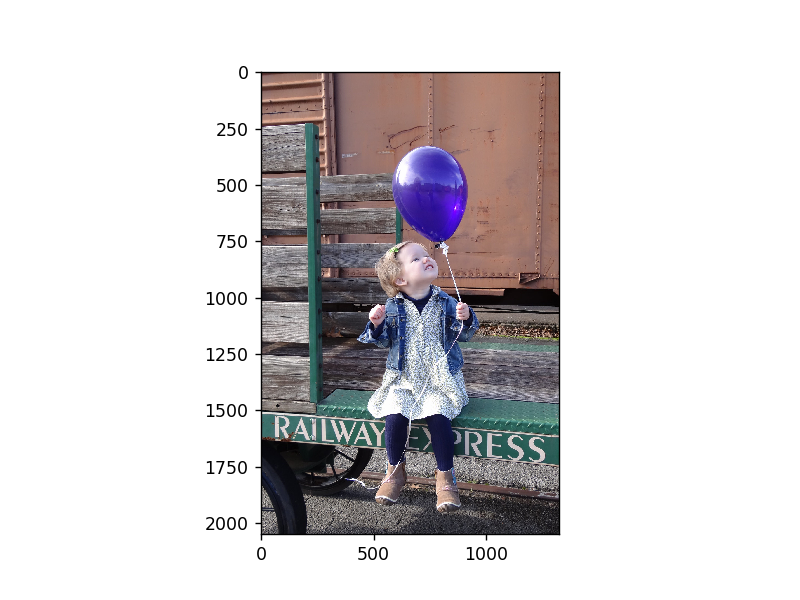

(2048, 1323, 1) [2]


In [56]:
import matplotlib
%matplotlib notebook
plt.imshow(balloon_val.load_image(0))
plt.show()

print(balloon_val.load_mask(0)[0].shape,balloon_val.load_mask(0)[1])

Nous voyons donc bien que la dataset a correctement été chargée.

# Entrainement du Mask-RCNN

Maintenant que les données sont prêtes, nous pouvons entrer dans le vif du sujet et entrainer le Mask-RCNN. Pour ce faire, nous allons utiliser la méthode ```train()``` de SmartMov. Cette méthode prend les paramètres suivant :
* 'rcnn' : spécifie que nous entrainons uniquement le Mask-RCNN
* 'dataset_train_rcnn' : objet que nous venons d'inctancier qui correspond aux images d'entrainement et leurs annotations
* 'dataset_val_rcnn' : objet que nous venons d'inctancier qui correspond aux images de validation et leurs annotations
* 'epochs_rcnn' : nombre d'epochs à réaliser lors de l'entrainement
* 'layers' : couches du réseau à entrainer. Lorsque nous partons d'un modèle pré-entrainé nous n'entrainons qu'une partie du réseau et il convient de spécifier 'heads' pour cet argument

Ainsi, l'entrainement se réalise de cette manière :

In [57]:
smartmov.train('rcnn',dataset_train_rcnn=balloon_train,dataset_val_rcnn=balloon_val,
               epochs_rcnn=3, layers_rcnn='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Jacques\Documents\Cours\2019-2020 IESE5\Projet\SmartMov\models/Mask-RCNN/logs/balloon20200318T1305\mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribu

D:\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


62/62 [==============================] - 259s 4s/step - loss: nan - rpn_class_loss: 0.6194 - rpn_bbox_loss: 0.3881 - mrcnn_class_loss: nan - mrcnn_bbox_loss: 0.0070 - mrcnn_mask_loss: 0.1305 - val_loss: nan - val_rpn_class_loss: 0.5470 - val_rpn_bbox_loss: 0.6171 - val_mrcnn_class_loss: nan - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/3
39/62 [=================>............] - ETA: 42s - loss: nan - rpn_class_loss: 0.5101 - rpn_bbox_loss: 0.4612 - mrcnn_class_loss: nan - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

KeyboardInterrupt: 

Une fois l'entrainement terminé, nous devons convertir le modèle en mode inference avant de pouvoir le sauvegarder. Ceci se fait en deux temps avec les méthodes de SmartMov ```convert_rcnn()``` et ```save()```. Nous réalisons cela de la manière suivante :

In [59]:
smartmov.convert_rcnn()
smartmov.save(models_to_save='rcnn',dir_rcnn=os.path.join(MODELS_MASKRCNN_DIR,"mask_rcnn_balloon2.h5"))

Dans ce cas, la méthode ```save()``` prends deux paramètres qui sont :
* 'models_to_save' : spécifie que le modèle à sauvegarder est le Mask-RCNN
* 'dir_rcnn' : emplacement ou enregsitrer les poids du modèle entrainé (fichier .h5)

# Prédiction avec le Mask-RCNN

Nous pouvons maintenant réaliser la prédiction sur une image. Pour ce faire, nous allons utiliser l'image que nous avons chargé plus haut :

<IPython.core.display.Javascript object>


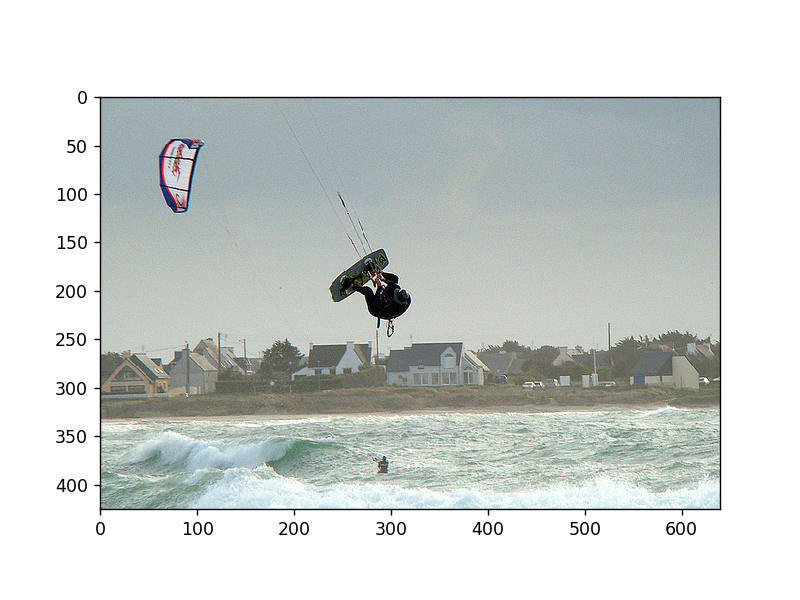

In [61]:
image = balloon_val.load_image(0) # On charge l'image sur laquelle réaliser la prédiction
pred = smartmov.predict(image,models_to_use='rcnn') # On réalise la prédiction
image_masked = smartmov.visualize(image,pred,models_used='rcnn') # On affiche la prédiction

Nous voyons donc que la prédiction a bien été réalisée, ce qui signifie que le modèle s'est entrainé correctement.

# Entrainement du Mask-RCNN sur plusieurs datasets

Il est également possible d'entrainer le Mask-RCNN sur deux datasets. Pour ce faire, nous allons tenter d'entrainer ce modèle sur les ballons et également sur les personnes. Une classe *UnionDataset* a été crée pour faire cela. La classe *UnionDataset* permet de réunir d'autres dataset en une seule.

Dans un premier temps, nous allons donc importer les datasets COCO2014 sur les humains ainsi que la dataset balloon que nous avons utilisé jusqu'ici. Il faut noter que dans ce cas, les identifiants des classes doivent être différents. L'identifiant des humains dans la dataset COCO est 1, ce qui signifie que nous ne pourrons pas cette fois avoir pour identifiant 1 pour la classe des ballons. Nous prenons donc 2.

Dans un premier temps, nous chargeons les datasets de train et de validation de COCO :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import PIL
import cv2
import json
import skimage.draw

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn.utils import Dataset
import union
import coco
from SmartMov import SmartMov
from utils import sorted_nicely

In [2]:
DATASET_DIR = os.path.join(ROOT_DIR,"../Datasets/")
BALLOON_DIR = os.path.join(DATASET_DIR,"balloon/")
print(os.listdir(BALLOON_DIR))

['train', 'val']


In [3]:
COCO_DIR = os.path.join(DATASET_DIR,"coco2014/")

coco_train = coco.CocoDataset() # Objet qui va contenir les images et les masques de validation
cc = coco_train.load_coco(COCO_DIR, "train", year='2014', auto_download=True, return_coco=True, class_ids=[1])
coco_train.prepare()

coco_val = coco.CocoDataset() # Objet qui va contenir les images et les masques de validation
cc = coco_val.load_coco(COCO_DIR, "minival", year='2014', auto_download=True, return_coco=True, class_ids=[1])
coco_val.prepare()

Will use images in D:\Jacques\Documents\Cours\2019-2020 IESE5\Projet\SmartMov\../Datasets/coco2014//train2014
Will use annotations in D:\Jacques\Documents\Cours\2019-2020 IESE5\Projet\SmartMov\../Datasets/coco2014//annotations/instances_train2014.json
loading annotations into memory...
Done (t=18.93s)
creating index...
index created!
Will use images in D:\Jacques\Documents\Cours\2019-2020 IESE5\Projet\SmartMov\../Datasets/coco2014//val2014
Will use annotations in D:\Jacques\Documents\Cours\2019-2020 IESE5\Projet\SmartMov\../Datasets/coco2014//annotations/instances_minival2014.json
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


Maintenant nous chargeons nos datasets de train et de validation avec nos ballons, en précisant bien que l'identifiant de la classe doit être 2 :

In [6]:
balloon_train = BalloonDataset()
balloon_train.load_balloon(BALLOON_DIR,'train',class_id=2)
balloon_train.prepare()

balloon_val = BalloonDataset()
balloon_val.load_balloon(BALLOON_DIR,'val',class_id=2)
balloon_val.prepare()

Nous utilisons ensuite la classe *UnionDataset* pour réunir ces deux datasets au sein du même objet. La méthode ```load_union()``` prend en paramètre d'abord le nombre d'images à selectionner dans chaque dataset (il faut pour un bon entrainement que chaque classe ait a peu près le même nombre d'exemples), puis ensuite les datasets à réunir. Nous créons donc nos datasets globales de train et de validation :

In [7]:
union_train = union.UnionDataset()
union_train.load_union(60,balloon_train,coco_train)
union_train.prepare()

union_val = union.UnionDataset()
union_val.load_union(15,balloon_val,coco_val)
union_val.prepare()

Nous pouvons observer que nous avons bien des images des deux datasets dans le même objet :

<IPython.core.display.Javascript object>


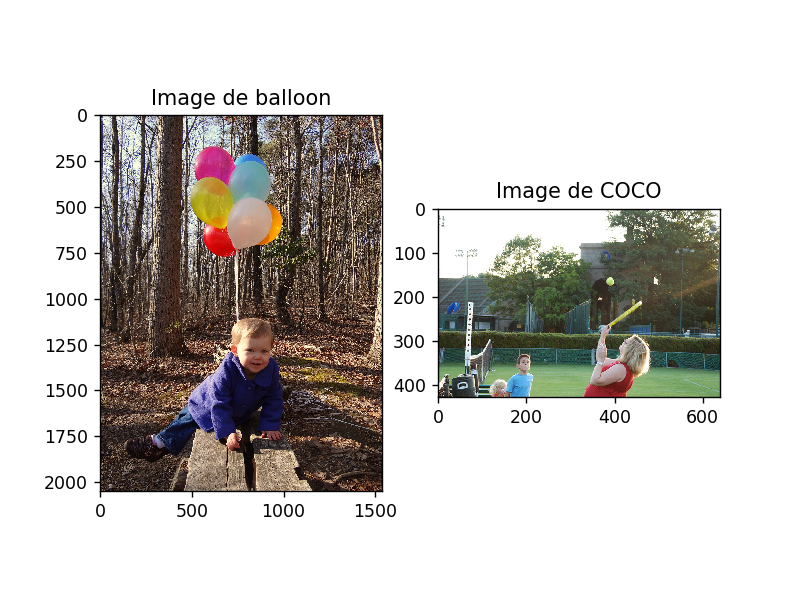

Text(0.5, 1.0, 'Image de COCO')

In [8]:
%matplotlib notebook
plt.figure()
plt.subplot(121)
plt.imshow(union_val.load_image(1))
plt.title('Image de balloon')
plt.subplot(122)
plt.imshow(union_val.load_image(20))
plt.title('Image de COCO')
plt.show()

Il faut remarquer que dans ce cas, l'entrainement ne sera pas optimal, étant donné qu'il existe des images de la dataset balloon dans lesquelles les humains ne seront pas détourés, et il existe des images de la dataset COCO dans lesquelles les ballons ne seront pas détourés. Pour que l'entrainement se passe du mieux possible, il faudrait s'assurer que chaque type d'objet soit bien détouré sur chaque image. L'intérêt de cette partie est de montrer que même avec des annotations peu complètes, les résultats peuvent être intéressants.

Nous allons à présent recréer notre modèle et le ré-entrainer. Nous rechargeons d'abord l'emplacement des poids à utiliser.

In [9]:
MODELS_DIR = os.path.join(ROOT_DIR,"models/")
MODELS_MASKRCNN_DIR = os.path.join(MODELS_DIR,"Mask-RCNN/")
print(os.listdir(MODELS_MASKRCNN_DIR))

['logs', 'mask_rcnn_balloon.h5', 'mask_rcnn_balloon2.h5', 'mask_rcnn_balloon_person_car.h5', 'mask_rcnn_coco.h5', 'mask_rcnn_only_car.h5', 'mask_rcnn_only_person.h5', 'mask_rcnn_person_car_v2.h5']


Nous modifions la configuration du réseau pour que toutes les images du train soient utilisées (```STEPS_PER_EPOCH=120```) et pour que le bon nombre de classes soit détectées (```NUM_CLASSES=1+2```) :

In [10]:
class InferenceConfig(Config):
    NAME = "balloon_person"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 2
    STEPS_PER_EPOCH = 120
    DETECTION_MIN_CONFIDENCE = 0.9

config = InferenceConfig()

Nous créons ensuite les noms des classes en cohérence avec les données chargées dans les datasets (0 pour le background, 1 pour les humains et 2 pour les ballons) :

In [11]:
class_names = ['BG','person','balloon']

De la même manière que précédemment, nous utilisons les méthodes de SmartMov, nous instancions donc d'abord SmartMov avant de créer le modèle comme dans la première partie :

In [12]:
smartmov=SmartMov()

In [13]:
smartmov.create_model('rcnn',model_dir=MODELS_MASKRCNN_DIR+"logs/",config=config,reuse=True,
                      model_rcnn=MODELS_MASKRCNN_DIR+"mask_rcnn_coco.h5",class_names=class_names)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Nous réalisons ensuite l'entrainement à partir de nos deux datasets issues de l'union. Nous réalisons 3 epochs pour cette fois :

In [14]:
smartmov.train('rcnn',dataset_train_rcnn=union_train,dataset_val_rcnn=union_val,
               epochs_rcnn=3, layers_rcnn='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Jacques\Documents\Cours\2019-2020 IESE5\Projet\SmartMov\models/Mask-RCNN/logs/balloon_person20200318T1519\mask_rcnn_balloon_person_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2       

D:\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
D:\Anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


120/120 [==============================] - 378s 3s/step - loss: 1.3581 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.3094 - mrcnn_class_loss: 0.1810 - mrcnn_bbox_loss: 0.5877 - mrcnn_mask_loss: 0.2428 - val_loss: 0.9512 - val_rpn_class_loss: 0.0413 - val_rpn_bbox_loss: 0.2385 - val_mrcnn_class_loss: 0.1250 - val_mrcnn_bbox_loss: 0.3373 - val_mrcnn_mask_loss: 0.2091
Epoch 2/3
120/120 [==============================] - 306s 3s/step - loss: 0.9059 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.2814 - mrcnn_mask_loss: 0.1981 - val_loss: 0.9016 - val_rpn_class_loss: 0.0254 - val_rpn_bbox_loss: 0.3113 - val_mrcnn_class_loss: 0.1201 - val_mrcnn_bbox_loss: 0.2530 - val_mrcnn_mask_loss: 0.1918
Epoch 3/3
120/120 [==============================] - 303s 3s/step - loss: 0.7393 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2344 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.2019 - mrcnn_mask_loss: 0.1926 - val_loss: 0.8142 - val_rpn_class_loss: 0.0168 -

Nous pouvons alors convertir notre modèle en mode inférence et le sauvegarder comme ceci :

In [15]:
smartmov.convert_rcnn()
smartmov.save(models_to_save='rcnn',dir_rcnn=os.path.join(MODELS_MASKRCNN_DIR,"mask_rcnn_balloon_person.h5"))

Maintenant, nous sommes en mesure de réaliser la prédiciton sur des ballons ou bien sur des humains :

<IPython.core.display.Javascript object>


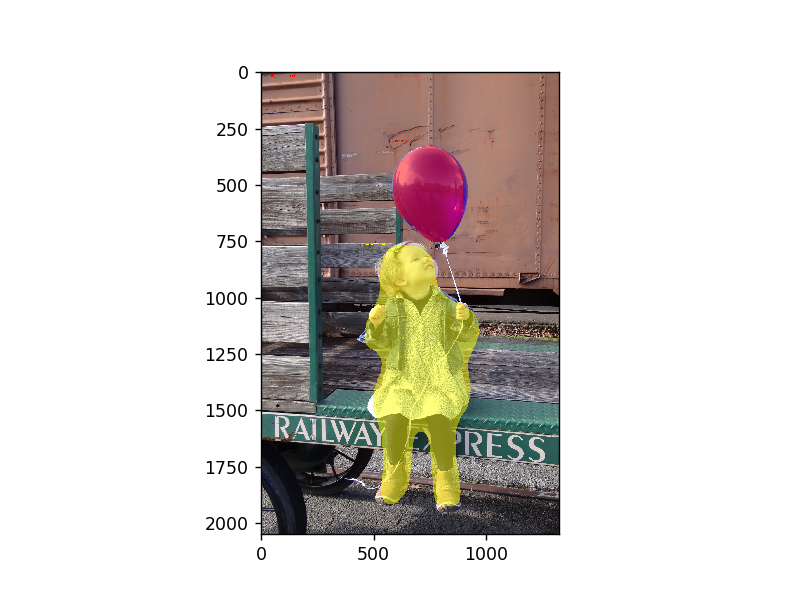

<IPython.core.display.Javascript object>


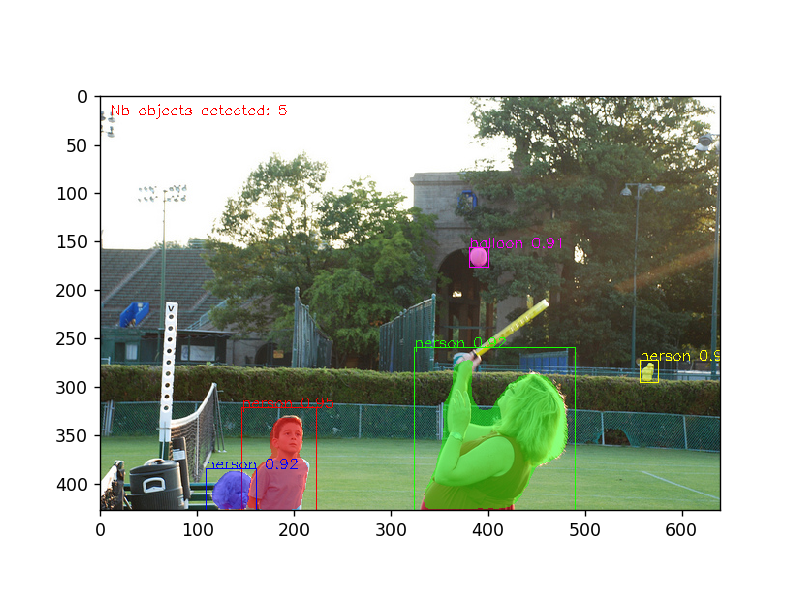

In [28]:
image = balloon_val.load_image(0) # On charge l'image sur laquelle réaliser la prédiction
pred = smartmov.predict(image,models_to_use='rcnn') # On réalise la prédiction
image_masked = smartmov.visualize(image,pred,models_used='rcnn') # On affiche la prédiction

image = coco_val.load_image(7) # On charge l'image sur laquelle réaliser la prédiction
pred = smartmov.predict(image,models_to_use='rcnn') # On réalise la prédiction
image_masked = smartmov.visualize(image,pred,models_used='rcnn') # On affiche la prédiction

Nous voyons bien sur cet exemple que cette fois, le réseau a été en mesure de détecter à la fois les ballons et l'enfant, ce qui est bien ce que nous souhaitions.

Le réseau est bien entendu toujours capable de détecter les humains sur les images ou il n'y a que des humains, ou des ballons sur des images ou il n'y a que des ballons :

<IPython.core.display.Javascript object>


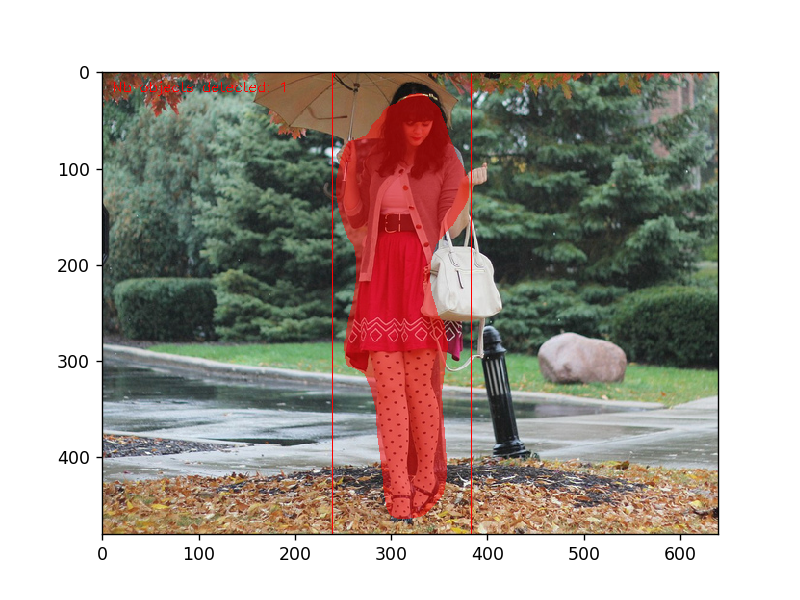

<IPython.core.display.Javascript object>


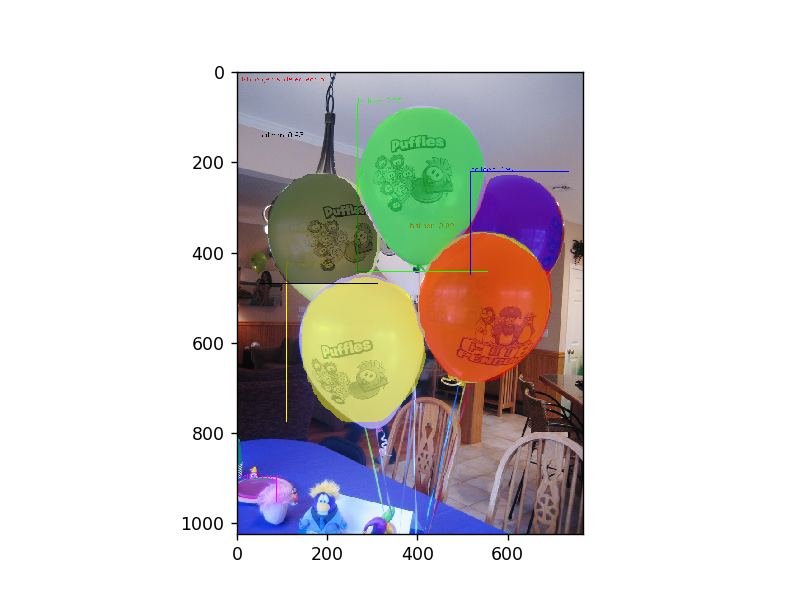

In [23]:
image = coco_val.load_image(10) # On charge l'image sur laquelle réaliser la prédiction
pred = smartmov.predict(image,models_to_use='rcnn') # On réalise la prédiction
image_masked = smartmov.visualize(image,pred,models_used='rcnn') # On affiche la prédiction

image = balloon_val.load_image(5) # On charge l'image sur laquelle réaliser la prédiction
pred = smartmov.predict(image,models_to_use='rcnn') # On réalise la prédiction
image_masked = smartmov.visualize(image,pred,models_used='rcnn') # On affiche la prédiction

Nous remarquons cependant qu'étant donné que les annotations n'étaient pas de très bonne qualité, nous pouvons avoir des surprises comme sur l'exemple suivant ou l'enfant n'est pas détecté :

<IPython.core.display.Javascript object>


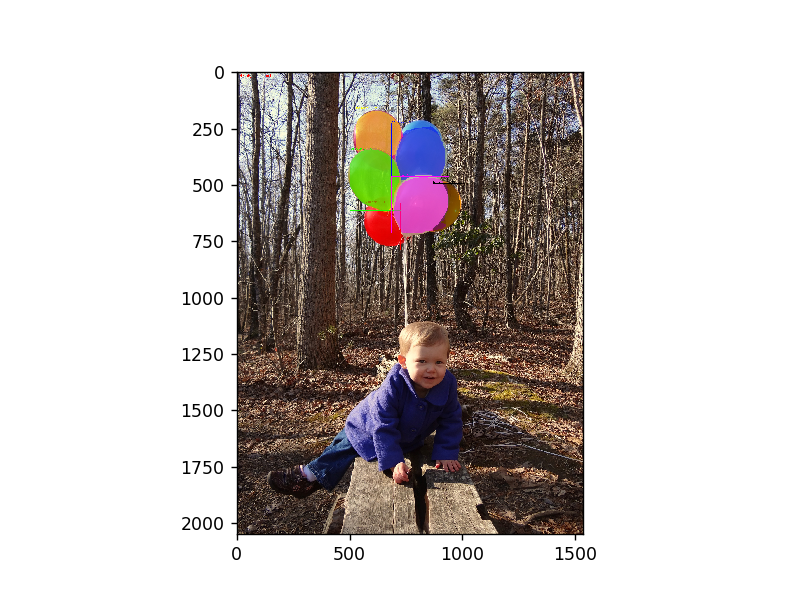

In [27]:
image = balloon_val.load_image(1) # On charge l'image sur laquelle réaliser la prédiction
pred = smartmov.predict(image,models_to_use='rcnn') # On réalise la prédiction
image_masked = smartmov.visualize(image,pred,models_used='rcnn') # On affiche la prédiction

Cette méthode n'est a utiliser que si aucune autre méthode n'est envisageable. En effet :
* Il faut privilégier regrouper toutes les images intéressantes dans un seul objet sans passer par cette classe
* Cette classe est en version beta, elle est loin d'être terminée
* Les problèmes d'annotations rendant vite les résultats inutilisables peuvent arriver très vite
* La gestion des identifiants de classes reste approximative